# Tutoriel Python

Ce tutoriel a pour but de guider les personnes souhaitant utiliser Python pour participer au challenge.

Il comporte cinq etapes :

* Import des donnees
* Analyse descriptive
* Preparation des donnees
* Creation d’un modele en cross validation
* Calcul des predictions et soumission

# Import des données

Avant de rentrer dans le vif du sujet, importons quelques packages necessaires pour ce tutoriel :

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.linear_model import ElasticNet
%matplotlib inline 

C:\Users\Peter martigny\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Librairie de visualisation super cool
import seaborn as sns # pip install seaborn

Les datasets sont sous format .csv. Vous pouvez les importer avec le code ci-dessous.

In [3]:
train = pd.read_csv('boites_medicaments_train.csv',
                    encoding='utf-8',
                    sep=';')

test = pd.read_csv('boites_medicaments_test.csv',
                   encoding='utf-8', 
                   sep=';')

In [4]:
pd.set_option("display.max_columns", 99) # permet de voir toutes les colonnes
train.head(2)

,libelle,libelle_plaquette,libelle_ampoule,libelle_flacon,libelle_tube,libelle_stylo,libelle_seringue,libelle_pilulier,libelle_sachet,libelle_comprime,libelle_gelule,libelle_film,libelle_poche,libelle_capsule,nb_plaquette,nb_ampoule,nb_flacon,nb_tube,nb_stylo,nb_seringue,nb_pilulier,nb_sachet,nb_comprime,nb_gelule,nb_film,nb_poche,nb_capsule,nb_ml,statut,etat commerc,agrement col,tx rembours,forme pharma,voies admin,statut admin,date declar annee,date amm annee,type proc,titulaires,substances,prix
0,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,1,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé pelliculé,orale,Autorisation active,2014,2014,Procédure décentralisée,MAJORELLE LUXEMBOURG SOPARFI (LUXEMBOURG),DÉSOGESTREL,2.83
1,plaquette(s) thermoformée(s) aluminium de 28 c...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé à croquer,orale,Autorisation active,2013,2009,Procédure de reconnaissance mutuelle,TEVA SANTE,"MONTÉLUKAST ACIDE, MONTÉLUKAST SODIQUE",14.30


On est maintenant pret a attaquer les choses serieuses ! :)

# Analyse descriptive

### Structure des datasets

Le dataset ```train``` comporte les caracteristiques et prix de 8564 boites de medicaments. C'est ce dataset que nous allons utiliser pour creer un modele.
Chaque boite de medicament est decrite par une observation de 41 variables. Ces variables sont decrites dans le fichier `Description.pdf` present dans la cle usb.

Le dataset ```test``` comporte les caracteristiques des 3671 boites de medicaments dont il faut predire le prix. A la difference de ```train```, le prix des boites de medicaments n'est bien sur pas inclus et une colonne `id` a ete ajoutée pour identifier les boites de medicaments pendant l'etape de soumission des predictions sur [Datascience.net](www.datascience.net)

### Distribution des donnees

Jetons maintenant un coup d'oeil a la distribution des donnees

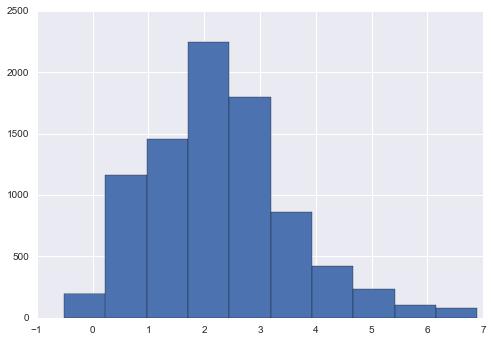

In [5]:
# Distribution du log des prix
# On prend le log des prix car sa distribution est plus proche d'une gaussienne
train['logprix'] = train['prix'].apply(np.log)
train['tx rembours'] = train['tx rembours'].apply(lambda x: float(x[0:-1]))
test['tx rembours'] = test['tx rembours'].apply(lambda x: float(x[0:-1]))
train['logprix'].hist()

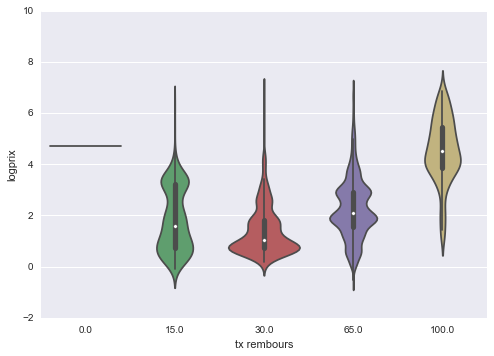

In [6]:
# Influence sur les prix de la feature "tx rembours"
sns.violinplot(y="logprix", x="tx rembours", data=train)

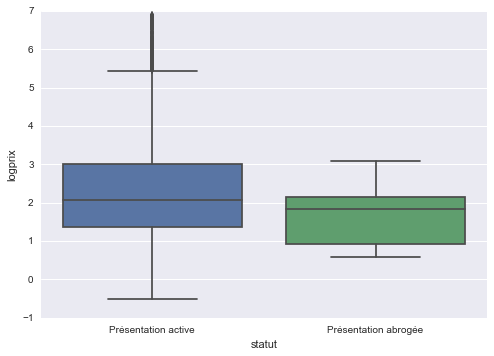

In [7]:
# Influence sur les prix de la feature "statut"
sns.boxplot(y="logprix", x="statut", data=train)

# Preparation des donnees

### Types de features

In [8]:
# features numériques
feat_num = ['libelle_plaquette', 'libelle_ampoule', 'libelle_flacon', 
            'libelle_tube', 'libelle_stylo', 'libelle_seringue',
            'libelle_pilulier', 'libelle_sachet', 'libelle_comprime', 
            'libelle_gelule', 'libelle_film', 'libelle_poche',
            'libelle_capsule'] + ['nb_plaquette', 'nb_ampoule', 
            'nb_flacon', 'nb_tube', 'nb_stylo', 'nb_seringue',
            'nb_pilulier', 'nb_sachet', 'nb_comprime', 'nb_gelule', 
            'nb_film', 'nb_poche', 'nb_capsule', 'nb_ml', 'tx rembours']
# features date
feat_dates = ['date declar annee', 'date amm annee']
# features catégorielles
feat_cat = ['statut', 'etat commerc', 'agrement col',
          'voies admin', 'statut admin', 'type proc']
# features texte
feat_text = ['libelle', 'titulaires','substances', 'forme pharma']

### Encodage des features catégorielles

Les algorithmes de machine learning s'attendent à avoir en entrée des nombres, et non pas des chaînes de caractères. C'est pourquoi nous transformons les features catégorielles en nombres, à l'aide de LabelEncoder()

In [9]:
for c in feat_cat:
    le = LabelEncoder()
    le.fit(train[c].append(test[c]))
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

# Features engineering

In [10]:
train['substance_number'] = train['substances'].apply(lambda x: len(x.split()))
test['substance_number'] = test['substances'].apply(lambda x: len(x.split()))

In [11]:
for i in range(0, 100):
    print(train['substances'][i])

DÉSOGESTREL
MONTÉLUKAST ACIDE, MONTÉLUKAST SODIQUE
CHLORHYDRATE DE DILTIAZEM
ACIDE VALPROÏQUE, VALPROATE DE SODIUM
LÉTROZOLE
FLUTAMIDE
BEXAROTÈNE
GLIMÉPIRIDE
MALÉATE D'ÉNALAPRIL
CEFPODOXIME PROXÉTIL, CEFPODOXIME
ESTRADIOL, ESTRADIOL HÉMIHYDRATÉ
FUMARATE DE FORMOTÉROL DIHYDRATÉ, BUDÉSONIDE
PRAVASTATINE SODIQUE
PÉRINDOPRIL TERT-BUTYLAMINE, PÉRINDOPRIL, INDAPAMIDE
TELMISARTAN
TRIHEXYPHÉNIDYLE (CHLORHYDRATE DE)
PHLOROGLUCINOL HYDRATÉ
ACICLOVIR
ZUCLOPENTHIXOL (DICHLORHYDRATE DE), ZUCLOPENTHIXOL
CHLORHYDRATE DE TRAMADOL
HYDROCHLOROTHIAZIDE, CANDÉSARTAN CILEXÉTIL
LÉVOFLOXACINE HÉMIHYDRATÉE, LÉVOFLOXACINE
CHLORHYDRATE DE TRAMADOL
BROMAZÉPAM
OXALATE D'ESCITALOPRAM, ESCITALOPRAM
GLIMÉPIRIDE
FENTANYL
INDAPAMIDE HÉMIHYDRATÉ
OMÉPRAZOLE
PROGESTÉRONE
SULPIRIDE
LATANOPROST
RILMÉNIDINE (DIHYDROGÉNOPHOSPHATE DE), RILMÉNIDINE
LOPÉRAMIDE BASE, CHLORHYDRATE DE LOPÉRAMIDE
HYDROCHLOROTHIAZIDE, MALÉATE D'ÉNALAPRIL
GUÊPE VESPILA (VENIN DE)
TRANDOLAPRIL
ZONISAMIDE
POLYMYXINE B (SULFATE DE), DEXAMÉTHASONE (MÉTAS

In [12]:
def alcohol(x):
    x = x.lower()
    if 'ol' in x:
        return 1
    else:
        return 0
train['alcohol'] = train['substances'].apply(lambda x: alcohol(x))

def cetone(x):
    x = x.lower()
    if 'one' in x:
        return 1
    else:
        return 0
train['cetone'] = train['substances'].apply(lambda x: cetone(x))

def potasse(x):
    x = x.lower()
    if 'potass' in x:
        return 1
    else:
        return 0
train['potasse'] = train['substances'].apply(lambda x: potasse(x))

def met(x):
    x = x.lower()
    if 'met' in x:
        return 1
    else:
        return 0
train['met'] = train['substances'].apply(lambda x: met(x))

def hydro(x):
    x = x.lower()
    if 'hydr' in x:
        return 1
    else:
        return 0
train['hydro'] = train['substances'].apply(lambda x: hydro(x))
    
def chlor(x):
    x = x.lower()
    if 'chlor' in x:
        return 1
    else:
        return 0
train['chlor'] = train['substances'].apply(lambda x: chlor(x))
    
def glucose(x):
    x = x.lower()
    if 'gluc' in x:
        return 1
    else:
        return 0
train['glucose'] = train['substances'].apply(lambda x: glucose(x))
    
def acide(x):
    x = x.lower()
    if 'acide' in x:
        return 1
    else:
        return 0
train['acide'] = train['substances'].apply(lambda x: acide(x))
    
def ique(x):
    x = x.lower()
    if ('ique' in x) | ('ïque' in x):
        return 1
    else:
        return 0
train['ique'] = train['substances'].apply(lambda x: ique(x)) 

def ate(x):
    x = x.lower()
    if 'ate' in x:
        return 1
    else:
        return 0
train['ate'] = train['substances'].apply(lambda x: ate(x))
    
def amine(x):
    x = x.lower()
    if 'ine' in x:
        return 1
    else:
        return 0
train['amine'] = train['substances'].apply(lambda x: amine(x))
    
def amide(x):
    x = x.lower()
    if 'ide' in x:
        return 1
    else:
        return 0
train['amide'] = train['substances'].apply(lambda x: amide(x))
    
def di(x):
    x = x.lower()
    if 'di' in x:
        return 1
    else:
        return 0
train['di'] = train['substances'].apply(lambda x: di(x))
    
def tri(x):
    x = x.lower()
    if 'tri' in x:
        return 1
    else:
        return 0
train['tri'] = train['substances'].apply(lambda x: tri(x))
    
def des(x):
    x = x.lower()
    if ('dés' in x) | ('des' in x):
        return 1
    else:
        return 0
train['des'] = train['substances'].apply(lambda x: des(x))
    
def yl(x):
    x = x.lower()
    if ('il' in x) | ('yl' in x):
        return 1
    else:
        return 0
train['yl'] = train['substances'].apply(lambda x: yl(x))
    
def thio(x):
    x = x.lower()
    if ('thio' in x) | ('thia' in x):
        return 1
    else:
        return 0
train['thio'] = train['substances'].apply(lambda x: thio(x))
    
def poly(x):
    x = x.lower()
    if 'poly' in x:
        return 1
    else:
        return 0
train['poly'] = train['substances'].apply(lambda x: poly(x))
    
def sulfure(x):
    x = x.lower()
    if 'sulf' in x:
        return 1
    else:
        return 0
train['sulfure'] = train['substances'].apply(lambda x: sulfure(x))

chemistry_features = ['sulfure', 'poly', 'thio', 'yl', 'des', 'tri', 'di', 'amide', 'amine', 'ate', 'ique', 'acide', 
                'glucose', 'chlor', 'hydro', 'alcohol', 'cetone', 'substance_number', 'met', 'potasse']

In [13]:
test['alcohol'] = test['substances'].apply(lambda x: alcohol(x))
test['hydro'] = test['substances'].apply(lambda x: hydro(x))
test['chlor'] = test['substances'].apply(lambda x: chlor(x))
test['glucose'] = test['substances'].apply(lambda x: glucose(x))
test['acide'] = test['substances'].apply(lambda x: acide(x))
test['ique'] = test['substances'].apply(lambda x: ique(x)) 
test['ate'] = test['substances'].apply(lambda x: ate(x))
test['amine'] = test['substances'].apply(lambda x: amine(x))
test['amide'] = test['substances'].apply(lambda x: amide(x))
test['di'] = test['substances'].apply(lambda x: di(x))
test['tri'] = test['substances'].apply(lambda x: tri(x))
test['des'] = test['substances'].apply(lambda x: des(x))
test['yl'] = test['substances'].apply(lambda x: yl(x))
test['thio'] = test['substances'].apply(lambda x: thio(x))
test['poly'] = test['substances'].apply(lambda x: poly(x))
test['sulfure'] = test['substances'].apply(lambda x: sulfure(x))
test['cetone'] = test['substances'].apply(lambda x: cetone(x))
test['met'] = test['substances'].apply(lambda x: met(x))
test['potasse'] = test['substances'].apply(lambda x: potasse(x))


feture engineering sur les formes pharma

In [14]:
train['forme pharma'].value_counts()

comprimé pelliculé                                                  1931
comprimé                                                            1017
comprimé sécable                                                     812
comprimé pelliculé sécable                                           669
gélule                                                               639
solution injectable                                                  496
gélule gastro-résistant(e)                                           256
gélule à libération prolongée                                        175
comprimé gastro-résistant(e)                                         160
comprimé orodispersible                                              136
poudre pour suspension buvable                                       124
solution buvable                                                     109
comprimé pelliculé à libération prolongée                            102
collyre en solution                                

In [15]:
def comprime(x):
    if 'comprim' in x:
        return 1
    else:
        return 0
train['comprime'] = train['forme pharma'].apply(lambda x: comprime(x))
test['comprime'] = test['forme pharma'].apply(lambda x: comprime(x))

def gelule(x):
    if 'gélul' in x:
        return 1
    else:
        return 0
train['gelule'] = train['forme pharma'].apply(lambda x: gelule(x))
test['gelule'] = test['forme pharma'].apply(lambda x: gelule(x))

def solution(x):
    if 'solution' in x:
        return 1
    else:
        return 0
train['solution'] = train['forme pharma'].apply(lambda x: solution(x))
test['solution'] = test['forme pharma'].apply(lambda x: solution(x))

def creme(x):
    if ('crème' in x) | ('gel' in x):
        return 1
    else:
        return 0
train['creme'] = train['forme pharma'].apply(lambda x: creme(x))
test['creme'] = test['forme pharma'].apply(lambda x: creme(x))

pharma_features = ['solution', 'gelule', 'comprime', 'creme']

Features engineering sur le fournisseur

In [16]:
def generique(x):
    if ('generi' in x.lower()):
        return 1
    else:
        return 0
train['generique'] = train['titulaires'].apply(lambda x: generique(x))
test['generique'] = test['titulaires'].apply(lambda x: generique(x))

In [17]:
train['generique'].sum()

1145

# Creation d'un modele

Il est maintenant temps de creer un modele. Dans ce tutoriel nous allons construire une [Foret Aleatoire](https://fr.wikipedia.org/wiki/For%C3%AAt_d'arbres_d%C3%A9cisionnels)

Pour ce faire nous utilisons toutes les variables dont nous disposons, sauf les variables de type "texte".

Pour eviter le [surapprentissage](https://fr.wikipedia.org/wiki/Surapprentissage) et estimer les vraies performances de notre modele nous allons utiliser le critère de [validation croisee](https://fr.wikipedia.org/wiki/Validation_crois%C3%A9e) (cross-validation) methode k-fold.

### Métrique MAPE

La métrique MAPE n'étant pas disponible dans scikit-learn, nous la codons

In [23]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [18]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

ValueError: Found input variables with inconsistent numbers of samples: [6852, 8564]

In [25]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

NameError: name 'cv_ridge' is not defined

### Cross validation

In [22]:
err = 0
NBROUND = 5
FEATURES = feat_num+feat_cat+chemistry_features+pharma_features+['generique'] # on n'utilise que ces features pour ce modèle basique
for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
    y = train['logprix']
    X = train[FEATURES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestRegressor(n_estimators=10, min_samples_split=2)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print(mape_error(np.exp(y_test), np.exp(pred)))
print("*** MAPE Error : ", err / NBROUND)

43.607067090438626
50.52991491732378
44.24999176194384
48.77829996982575
42.48933047573213
*** MAPE Error :  45.93092084305283


In [32]:
err = 0
NBROUND = 5
FEATURES = feat_num+feat_cat+chemistry_features+pharma_features # on n'utilise que ces features pour ce modèle basique
for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
    y = train['logprix']
    X = train[FEATURES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    clf = ExtraTreesRegressor()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print(mape_error(np.exp(y_test), np.exp(pred)))
print("*** MAPE Error : ", err / NBROUND)

40.31820013084989
54.792648908610296
42.131221188622064
47.054539719672874
40.5717992979864
*** MAPE Error :  44.973681849148306


In [50]:
mixture_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
results = []
for a in mixture_list:
    err1 = 0
    err2 = 0
    err3 = 0
    NBROUND = 5
    FEATURES = feat_num+feat_cat+chemistry_features+pharma_features+['generique'] # on n'utilise que ces features pour ce modèle basique
    for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
        y = train['logprix']
        X = train[FEATURES]
        X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf1 = RandomForestRegressor()
        clf2 = neighbors.KNeighborsRegressor(n_neighbors=10)
        clf1.fit(X_train, y_train)
        clf2.fit(X_train, y_train)
        pred1 = clf1.predict(X_test)
        pred2 = clf2.predict(X_test)
        pred3 = a*pred1 + (1-a)*pred2
        # ne pas oublier de reprendre l'exponentielle de la prédiction
        err1 += mape_error(np.exp(y_test), np.exp(pred1))
        err2 += mape_error(np.exp(y_test), np.exp(pred2))
        err3 += mape_error(np.exp(y_test), np.exp(pred3))
        print("random forest", mape_error(np.exp(y_test), np.exp(pred1)))
        print("extra tree", mape_error(np.exp(y_test), np.exp(pred2)))
        print("mixture", mape_error(np.exp(y_test), np.exp(pred3)))
    print("*** MAPE Error random forest: ", err1 / NBROUND)
    print("*** MAPE Error extra tree: ", err2 / NBROUND)
    print("*** MAPE Error mixture: ", err3 / NBROUND)
    results.append([a, err3 / NBROUND])

random forest 44.81835823677941
extra tree 61.09121606819996
mixture 61.09121606819996
random forest 50.268866031022405
extra tree 61.40504742639187
mixture 61.40504742639187
random forest 43.908931414713365
extra tree 54.579463482849455
mixture 54.579463482849455
random forest 48.1504702241763
extra tree 59.04784769227168
mixture 59.04784769227168
random forest 43.07449535170015
extra tree 54.78153824550748
mixture 54.78153824550748
*** MAPE Error random forest:  46.04422425167833
*** MAPE Error extra tree:  58.18102258304409
*** MAPE Error mixture:  58.18102258304409
random forest 45.41148006885222
extra tree 61.09121606819996
mixture 57.1884078117073
random forest 51.36582236019801
extra tree 61.40504742639187
mixture 58.55641002876069
random forest 44.57069685908566
extra tree 54.579463482849455
mixture 51.67317228207211
random forest 49.38374431178796
extra tree 59.04784769227168
mixture 55.575833752435166
random forest 43.08411296260207
extra tree 54.78153824550748
mixture 51.881

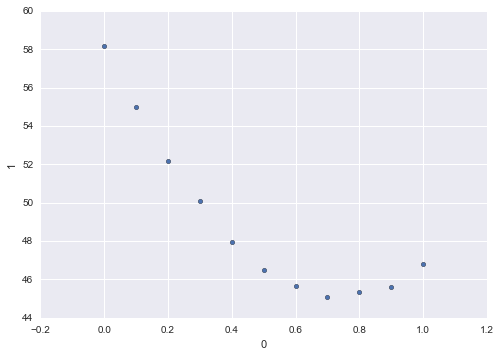

In [51]:
pd.DataFrame(results).plot(x = 0, y = 1, kind = "scatter")

In [46]:
from sklearn import svm
err = 0
NBROUND = 5
FEATURES = feat_num+feat_cat+chemistry_features+pharma_features # on n'utilise que ces features pour ce modèle basique
for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
    y = train['logprix']
    X = train[FEATURES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    clf = svm.SVR()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print(mape_error(np.exp(y_test), np.exp(pred)))
print("*** MAPE Error : ", err / NBROUND)

61.56534775957642
62.08963393424058
56.600319345041584
63.449532987047384
60.967503922312005
*** MAPE Error :  60.9344675896436


In [175]:
from sklearn import linear_model
err = 0
NBROUND = 5
FEATURES = feat_num+feat_cat+chemistry_features+pharma_features # on n'utilise que ces features pour ce modèle basique
for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
    y = train['logprix']
    X = train[FEATURES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    clf = linear_model.BayesianRidge()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print(mape_error(np.exp(y_test), np.exp(pred)))
print("*** MAPE Error : ", err / NBROUND)

93.95336124202565
94.18974007081167
94.39869324374158
89.85260008428163
89.4924595643573
*** MAPE Error :  92.37737084104357


In [49]:
from sklearn import neighbors
err = 0
NBROUND = 5
FEATURES = feat_num+feat_cat+chemistry_features+pharma_features # on n'utilise que ces features pour ce modèle basique
for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
    y = train['logprix']
    X = train[FEATURES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    clf = neighbors.KNeighborsRegressor(n_neighbors=10)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print(mape_error(np.exp(y_test), np.exp(pred)))
print("*** MAPE Error : ", err / NBROUND)

59.99539531773011
61.211308997173
54.52822212896533
59.100996050025024
54.54788905954806
*** MAPE Error :  57.87676231068831


In [185]:
from sklearn.linear_model import SGDRegressor
err = 0
NBROUND = 5
FEATURES = feat_num+feat_cat+chemistry_features+pharma_features # on n'utilise que ces features pour ce modèle basique
for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
    y = train['logprix']
    X = train[FEATURES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    clf = SGDRegressor()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print(mape_error(np.exp(y_test), np.exp(pred)))
print("*** MAPE Error : ", err / NBROUND)

inf
inf
inf
inf
inf
*** MAPE Error :  inf


In [189]:
from sklearn.ensemble import GradientBoostingRegressor
err = 0
NBROUND = 5
FEATURES = feat_num+feat_cat+chemistry_features+pharma_features # on n'utilise que ces features pour ce modèle basique
for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
    y = train['logprix']
    X = train[FEATURES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    clf = GradientBoostingRegressor()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print(mape_error(np.exp(y_test), np.exp(pred)))
print("*** MAPE Error : ", err / NBROUND)

73.77592940567224
75.19779283204721
71.59557209682364
73.27179759662422
72.3021500807896
*** MAPE Error :  73.22864840239139


In [202]:
pred

array([[ 2.43231547],
       [ 2.43231547],
       [ 2.43231547],
       ..., 
       [ 2.43231547],
       [ 2.43231547],
       [ 2.43231547]])

In [201]:
from sknn.mlp import Regressor, Layer

err = 0
NBROUND = 5
FEATURES = feat_num+feat_cat+chemistry_features+pharma_features # on n'utilise que ces features pour ce modèle basique
for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
    y = train['logprix']
    X = train[FEATURES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    clf = Regressor(
    layers=[
        Layer("Rectifier", units=10),
        Layer("Linear")],
    learning_rate=0.02,
    n_iter=10)
    clf.fit(np.array(X_train), np.array(y_train))
    pred = clf.predict(np.array(X_test))
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print(mape_error(np.exp(y_test), np.exp(pred)))
print("*** MAPE Error : ", err / NBROUND)

Exception: Data must be 1-dimensional

In [184]:
err = 0
NBROUND = 5
FEATURES = feat_num+feat_cat+chemistry_features+pharma_features # on n'utilise que ces features pour ce modèle basique
for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
    y = train['logprix']
    X = train[FEATURES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    clf = linear_model.LinearRegression()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print(mape_error(np.exp(y_test), np.exp(pred)))
print("*** MAPE Error : ", err / NBROUND)

94.40796232900186
96.4075068213745
94.66998421710548
90.14625472507133
89.24226567364916
*** MAPE Error :  92.97479475324047


In [160]:
err = 0
NBROUND = 5
FEATURES = feat_num+feat_cat+chemistry_features+pharma_features # on n'utilise que ces features pour ce modèle basique
for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
    y = train['logprix']
    X = train[FEATURES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    alpha = 0.01
    clf = ElasticNet(alpha=alpha, l1_ratio=0.8)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print(mape_error(np.exp(y_test), np.exp(pred)))
print("*** MAPE Error : ", err / NBROUND)

96.91272238364516
96.06976874908985
95.92695445753401
93.7958145163641
93.3774528212677
*** MAPE Error :  95.21654258558016


Cela veut dire notre modele predit les prix des medicaments avec environ 65% d’erreur en moyenne. Par exemple, si un medicament vaut reellement 10€, notre prediction sera de 16.5€ (ou 3.5€).

# Calcul des predictions et soumission

In [104]:
clf = RandomForestRegressor()
# On entraine de nouveau le modèle, cette fois sur l'intégralité des données
clf.fit(train[FEATURES], train['logprix'])
predictions = np.exp(clf.predict(test[FEATURES]))

In [105]:
pd.DataFrame(predictions, index=test['id']).to_csv('soumission.csv',  
                          header=['prix'],
                          sep = ';')

In [205]:
train.libelle[0]

'3 plaquette(s) thermoformée(s) PVC-Aluminium de 28 comprimé(s)'

In [210]:
train.head(30)

,libelle,libelle_plaquette,libelle_ampoule,libelle_flacon,libelle_tube,libelle_stylo,libelle_seringue,libelle_pilulier,libelle_sachet,libelle_comprime,libelle_gelule,libelle_film,libelle_poche,libelle_capsule,nb_plaquette,nb_ampoule,nb_flacon,nb_tube,nb_stylo,nb_seringue,nb_pilulier,nb_sachet,nb_comprime,nb_gelule,nb_film,nb_poche,nb_capsule,nb_ml,statut,etat commerc,agrement col,tx rembours,forme pharma,voies admin,statut admin,date declar annee,date amm annee,type proc,titulaires,substances,prix
0,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,1,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé pelliculé,orale,Autorisation active,2014,2014,Procédure décentralisée,MAJORELLE LUXEMBOURG SOPARFI (LUXEMBOURG),DÉSOGESTREL,2.83
1,plaquette(s) thermoformée(s) aluminium de 28 c...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé à croquer,orale,Autorisation active,2013,2009,Procédure de reconnaissance mutuelle,TEVA SANTE,"MONTÉLUKAST ACIDE, MONTÉLUKAST SODIQUE",14.30
2,plaquette(s) thermoformée(s) PVC-aluminium de ...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,gélule à libération prolongée,orale,Autorisation active,2000,1996,Procédure nationale,MYLAN SAS,CHLORHYDRATE DE DILTIAZEM,5.66
3,30 sachet(s)-dose(s) papier aluminium complexe...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,granulés à libération prolongée,orale,Autorisation active,2005,2004,Procédure nationale,SANOFI AVENTIS FRANCE,"ACIDE VALPROÏQUE, VALPROATE DE SODIUM",24.27
4,plaquette(s) thermoformée(s) PVC-Aluminium de ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0.0,Présentation active,Déclaration d'arrêt de commercialisation,non,100%,comprimé pelliculé,orale,Autorisation active,2015,2010,Procédure nationale,TEVA SANTE,LÉTROZOLE,59.94
5,plaquette(s) thermoformée(s) PVC-aluminium de ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,100%,comprimé,orale,Autorisation active,2001,2000,Procédure nationale,EG LABO - LABORATOIRES EUROGENERICS,FLUTAMIDE,27.17
6,flacon(s) polyéthylène haute densité (PEHD) de...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,100,0.0,Présentation active,Déclaration de commercialisation,oui,100%,capsule molle,orale,Autorisation active,2015,2001,Procédure centralisée,EISAI (ROYAUME-UNI),BEXAROTÈNE,877.83
7,plaquette(s) thermoformée(s) PVC polyéthylène ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé,orale,Autorisation active,2006,2006,Procédure de reconnaissance mutuelle,SANDOZ,GLIMÉPIRIDE,6.58
8,plaquette(s) thermoformée(s) PVC-Aluminium de ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0.0,Présentation active,Déclaration d'arrêt de commercialisation,oui,65%,comprimé sécable,orale,Autorisation active,2013,2002,Procédure nationale,ARROW GENERIQUES,MALÉATE D'ÉNALAPRIL,18.63
9,plaquette(s) polyamide aluminium PVC de 10 com...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,non,65%,comprimé pelliculé,orale,Autorisation active,2015,2012,Procédure nationale,ARROW GENERIQUES,"CEFPODOXIME PROXÉTIL, CEFPODOXIME",6.13


In [211]:
train.shape

(8564, 41)

In [213]:
train['date amm annee'].value_counts()

2009    717
2010    713
2008    655
2011    639
2006    442
2007    417
2012    404
2005    358
1998    317
1997    294
2003    269
2013    269
2014    249
2000    248
2004    248
1996    234
2001    224
1999    223
2002    215
1995    160
1988    120
1994    119
1992    110
1987    106
1990    104
1991     91
1989     80
1993     74
1986     68
2015     60
1984     53
1981     50
1982     50
1983     49
1985     43
1980     27
1979     26
1978     24
1977     14
1973      1
Name: date amm annee, dtype: int64

In [219]:
a = train.ix[5699] 
b = train.ix[5034]

In [222]:
a

libelle              1 flacon(s) en verre de 50 ml avec nécessaire ...
libelle_plaquette                                                    0
libelle_ampoule                                                      0
libelle_flacon                                                       1
libelle_tube                                                         0
libelle_stylo                                                        0
libelle_seringue                                                     1
libelle_pilulier                                                     0
libelle_sachet                                                       0
libelle_comprime                                                     0
libelle_gelule                                                       0
libelle_film                                                         0
libelle_poche                                                        0
libelle_capsule                                                      0
nb_pla

In [225]:
train['titulaires'].value_counts()

 TEVA SANTE                                            777
 SANOFI AVENTIS FRANCE                                 571
 MYLAN SAS                                             567
 BIOGARAN                                              496
 SANDOZ                                                456
 ARROW GENERIQUES                                      454
 EG LABO - LABORATOIRES EUROGENERICS                   404
 RANBAXY PHARMACIE GENERIQUES                          275
 ZYDUS FRANCE                                          256
 CRISTERS                                              205
 RATIOPHARM (ALLEMAGNE)                                197
 PFIZER HOLDING FRANCE                                 194
 ACTAVIS GROUP PTC (ISLANDE)                           144
 EVOLUPHARM                                            142
 KRKA (SLOVENIE)                                       120
 GLAXOSMITHKLINE                                       107
 NOVARTIS PHARMA                                        

In [255]:
train['agrement col'].value_counts()

oui    7022
non    1542
Name: agrement col, dtype: int64

In [256]:
train['tx rembours'].value_counts()

65%     7175
30%      656
15%      393
100%     339
0%         1
Name: tx rembours, dtype: int64

In [257]:
test['tx rembours'].value_counts()

65%     3094
30%      254
15%      200
100%     123
Name: tx rembours, dtype: int64

In [268]:
train[feat_num+feat_cat+['substances', 'forme pharma', 'libelle']].drop_duplicates().shape

(6134, 37)

In [262]:
train['etat commerc'].value_counts()

Déclaration de commercialisation                                      7262
Déclaration d'arrêt de commercialisation                              1250
Arrêt de commercialisation (le médicament n'a plus d'autorisation)      51
Déclaration de suspension de commercialisation                           1
Name: etat commerc, dtype: int64

In [264]:
test['etat commerc'].value_counts()

Déclaration de commercialisation                                      3133
Déclaration d'arrêt de commercialisation                               520
Arrêt de commercialisation (le médicament n'a plus d'autorisation)      18
Name: etat commerc, dtype: int64